In [106]:
from bmcs_shell.folding.fets2d3u1m import \
    FETS2D3U1M, FEWBShellMesh,XWBDomain, FECustomMesh
import numpy as np
from ibvpy.mats.mats2D.mats2D_elastic import MATS2DElastic
from ibvpy.mats.mats2D import \
    MATS2DScalarDamage

In [107]:
from bmcs_shell.folding.waterbomb_cell import WBElem

In [108]:
fets = FETS2D3U1M()

wb_mesh_0 = FECustomMesh(
#    X_Id = [[1.5,2,0], [7,3.5,0], [4,7,0]],
#    X_Id = [[-1,0,0], [1,0,0], [0,1,0]],
    X_Id = [[0,0,0], [1,0,0], [0,1,0]],
    I_Fi = [[0,1,2]],
    fets=fets
)
fixed_dofs_0 = [0,1,2,4,5,6,8]
loaded_dofs_0 = [3,7]

wb_mesh_1 = FECustomMesh(
    X_Id = [[0,-1,1], [0,1,1], [-2,0,0], [2,0,0]],
    I_Fi = [[0,1,2], [0,3,1]],
    fets=fets
)
fixed_dofs_1 = [2,5,6,7,8,10,11]
loaded_dofs_1 = [9]

wb_mesh_2 = FECustomMesh(
    X_Id = [[0,0,0], [2,0,0], [2,2,0], [2,0,0], [1,1,0]],
    I_Fi = [[0,1,4], [1,2,4], [2,3,4], [3,0,4]],
    fets=fets
)

fixed_dofs_2 = [0,1,2,5,8,9,10,11,14]
loaded_dofs_2 = [3,6]

wb_mesh_3 = FECustomMesh(
    X_Id = [[0,-1,1], [0,1,1], [2,0,0], [-2,0,0]],
    I_Fi = [[0,2,1], [0,3,1]],
    fets=fets
)

fixed_dofs_3 = [1,4,6,7,8,9,10,11]
loaded_dofs_3 = [2,5]

In [109]:
data = dict(alpha=1, a=5, b=9, c=4, n_phi_plus=1, n_x_plus=1)
wb = WBElem(**data)
wb_mesh = FEWBShellMesh(wb_cell=wb,**data)
fixed_nodes = np.array([1,2,3,4])
fixed_dofs = (fixed_nodes[:,np.newaxis] * 3 + np.arange(3)[np.newaxis,:]).flatten()
loaded_dofs = [2]

In [110]:
# wb_mesh = wb_mesh_3
# fixed_dofs = fixed_dofs_3
# loaded_dofs = loaded_dofs_3

In [111]:
xdomain = XWBDomain(
    mesh=wb_mesh
)

\begin{align}
 u_a = L_i u_{ia}
\end{align}
\begin{align}
\varepsilon_{ab} &= \frac{1}{2} 
\left(\frac{\partial u_a}{\partial x_b} + 
 \frac{\partial u_b}{\partial x_a}\right) \\ 
&= \frac{1}{2} 
\left( \delta_{ac} \delta_{bd} + \delta_{ad} \delta_{bc}\right) 
 \frac{\partial u_c}{\partial x_d} 
\\
&= 
 \frac{1}{2} 
\left( \delta_{ac} \delta_{bd} + \delta_{ad} \delta_{bc}\right) 
 \frac{\partial L_i}{\partial x_d} u_{ic}
\\ 
 &=
 \frac{1}{2} 
\left( \delta_{ac} \delta_{bd} + \delta_{ad} \delta_{bc}\right) 
\frac{\partial L_i}{\partial \eta_j} \frac{\partial \eta_j}{\partial x_d} u_{ic}
\end{align}

\begin{align}
L_1 &= \eta_1, L_2 = \eta_2, L_3 = 1 - \eta_1 - \eta_2 \\
\frac{\partial L_i}{\partial \eta_j} & = 
\left[
\begin{array}{rr}
1 & 0 \\ 0 & 1 \\ -1 &-1
\end{array}
\right]
\end{align}

\begin{align}
x_{a} = L_i x_{ia}
\end{align}
\begin{align}
\frac{\partial x_a}{\partial \eta_j}
& = \frac{\partial L_i}{\partial \eta_j} x_{ia}
\end{align}
\begin{align}
\end{align}

In [112]:
x_Ia = xdomain.X_Id[...,:-1]
x_Eia = x_Ia[xdomain.I_Ei]
delta = np.identity(2)
Diff1_abcd = 0.5 * (
    np.einsum('ac,bd->abcd', delta, delta) +
    np.einsum('ad,bc->abcd', delta, delta)
)
dN_mir = np.array([[[1,0],[0,1],[-1,-1]]], dtype=np.float_)
J_Emar = np.einsum('mir,Eia->Emar', dN_mir, x_Eia)
inv_J_Emra = np.linalg.inv(J_Emar)
det_J_Emra = np.linalg.det(J_Emar)
B_Eimabc = np.einsum('abcd,mir,Emrd->Eimabc',Diff1_abcd,dN_mir,inv_J_Emra)
U_Eic = np.array([[[0,0],[1,0],[0,1]]], dtype=np.float_)
eps_Emab = np.einsum('Eimabc,Eic->Emab', B_Eimabc, U_Eic)
#eps_Emab

In [113]:
B2_Eimabc = np.einsum('abcd,imr,Emrd->Eimabc',Diff1_abcd,xdomain.fets.dN_imr,inv_J_Emra)

In [114]:
#inv_J_Emra

In [115]:
eps2_Emab = np.einsum('Eimabc,Eic->Emab', xdomain.B1_Eimabc, U_Eic)
#eps2_Emab

In [116]:
E_ = 1000
nu_ = 0.

In [117]:
m = MATS2DElastic(E=E_, nu=nu_)
sig_Emab, D_Emabcd = m.get_corr_pred(eps_Emab, 0)
D_abcd = D_Emabcd[0,0]

In [118]:
xx, yy = wb_mesh.X_Id[:,:-1].T
xx, yy

(array([ 0.        ,  5.        , -5.        ,  5.        , -5.        ,
         2.16120911, -2.16120911]),
 array([ 0.        ,  8.57547855,  8.57547855, -8.57547855, -8.57547855,
         0.        ,  0.        ]))

In [119]:
y23 = yy[1] - yy[2]
y31 = yy[2] - yy[0]
y12 = yy[0] - yy[1] 
x32 = xx[2] - xx[1]
x13 = xx[0] - xx[2]
x21 = xx[1] - xx[0]
x23 = -x32
y32 = -y23
y13 = -y31
J_analytical = np.array([[[[x13,y13],[x23,y23]]]])
J_analytical
inv_J_analytical = np.linalg.inv(J_analytical)
inv_J_analytical
det_J_analytical = np.linalg.det(J_analytical)
J_analytical, det_J_analytical

(array([[[[ 5.        , -8.57547855],
          [10.        ,  0.        ]]]]),
 array([[85.75478554]]))

In [120]:
X_Eid = xdomain.X_Id[xdomain.I_Ei]
J_Emar = np.einsum('imr,Eia->Emra', xdomain.fets.dN_imr, X_Eid[...,:-1])
#J_Emar, xdomain.det_J_Em, xdomain.J_Emar

In [121]:
B_so = np.array(
    [
        [y23, 0, y31, 0, y12, 0],
        [0, x32, 0, x13, 0, x21],
        [x32,y23,x13,y31,x21,y12]
    ]
) / det_J_analytical[0,0]

In [122]:
#B_so

In [123]:
np.einsum('so,o->s', B_so, U_Eic.flatten())

array([ 0.1       ,  0.05830578, -0.04169422])

In [124]:
D_st = E_ / (1 - nu_**2) * np.array([[1, nu_, 0], [nu_, 1, 0], [0, 0, 0.5*(1-nu_)]])

In [125]:
k2_ij = np.einsum('so,st,tp->op', B_so, D_st, B_so) * det_J_analytical[0,0] / 2

In [126]:
#k2_ij

In [127]:
#m = MATS2DScalarDamage()

In [128]:
from ibvpy.bcond import BCDof

In [129]:
u_cntl = -100
bc_fixed = [BCDof(var= 'u', dof=dof, value=0 )
           for dof in fixed_dofs]
bc_loaded = [BCDof(var= 'f', dof=dof, value=u_cntl )
           for dof in loaded_dofs]

In [130]:
from ibvpy.sim.tstep_bc import TStepBC
from ibvpy.mats.viz3d_scalar_field import \
    Vis3DStateField, Viz3DScalarField

In [131]:
from ibvpy.mats.viz3d_tensor_field import \
    Vis3DTensorField, Viz3DTensorField

In [132]:
ts = TStepBC(
    domains=[(xdomain, m)],
    bc=bc_fixed + bc_loaded,
)

# m.hist.vis_record = {
#     'strain': Vis3DTensorField(var='eps_ab'),
# #     'stress': Vis3DTensorField(var='sig_ab'),
#    'damage': Vis3DStateField(var='omega_a'),
#     #        'kinematic hardening': Vis3DStateField(var='z_a')
# }

In [133]:
ts.fe_domain[0].tmodel

In [134]:
domain0 = ts.fe_domain[0]

\begin{align}
u_f &= T_{fb} U_b \\
f_e &= k_{ef} u_f \\
F_a &= T_{ea} f_e
\end{align}
\begin{align}
 F_a = K_{ab} U_b = T_{ea} k_{ef} T_{fb} U_b
\end{align}


In [135]:
s = ts.sim
s.tloop.k_max = 10
s.tline.step = 1
s.tloop.verbose = True
s.run()

t:	 0.00(0), 
	 1.00(1), 



In [136]:
import numpy as np
F_to = ts.hist.F_t
U_to = ts.hist.U_t
F_loaded = np.sum(F_to[:, loaded_dofs], axis=-1)
F_fixed = np.sum(F_to[:, fixed_dofs], axis=-1)
U_loaded = np.average(U_to[:, loaded_dofs], axis=-1)

In [137]:
F_loaded
U_loaded

array([ 0.        , -0.66596097])

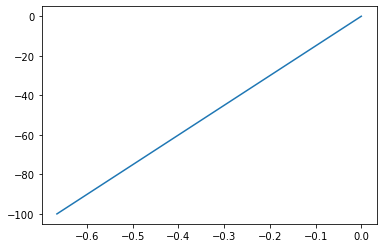

In [138]:
import matplotlib.pylab as plt
plt.plot(U_loaded, F_loaded)

In [139]:
U_1 = ts.hist.U_t[-1]
U_1.reshape(-1,3)

array([[-1.93266878e-17, -2.51072079e-17, -6.65960969e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.95255021e-01,  1.47317660e-17, -3.28721450e-01],
       [ 4.95255021e-01, -4.96135365e-17, -3.28721450e-01]])

In [140]:
X1_Id = xdomain.mesh.X_Id + (U_1.reshape(-1,3) * 1)
X1_Id

array([[-1.93266878e-17, -2.51072079e-17, -6.65960969e-01],
       [ 5.00000000e+00,  8.57547855e+00,  2.73151398e+00],
       [-5.00000000e+00,  8.57547855e+00,  2.73151398e+00],
       [ 5.00000000e+00, -8.57547855e+00,  2.73151398e+00],
       [-5.00000000e+00, -8.57547855e+00,  2.73151398e+00],
       [ 1.66595409e+00,  1.47317660e-17,  3.03716142e+00],
       [-1.66595409e+00, -4.96135365e-17,  3.03716142e+00]])

In [141]:
import k3d
k3d_plot = k3d.plot()
wb_cell_mesh_surfaces = k3d.mesh(xdomain.X_Id.astype(np.float32),
                                 xdomain.I_Ei.astype(np.uint32),
                                 color=0x999999,
                                 side='double')
k3d_plot += wb_cell_mesh_surfaces
wb_cell_mesh_surfaces1 = k3d.mesh(X1_Id.astype(np.float32),
                                 xdomain.I_Ei.astype(np.uint32),
                                 #color=0x999922,
                                 color_map=k3d.colormaps.basic_color_maps.Jet,
                                 attribute=U_1.reshape(-1,3)[:, 2],
                                 color_range=[-1.1, 2.01],
                                 side='double')
k3d_plot += wb_cell_mesh_surfaces1
k3d_plot.display()

Output()